In [9]:
%matplotlib inline
import bnpy
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import os
import pickle
import matplotlib.pyplot as plt
import gzip

from subprocess import Popen, PIPE
from threading import Timer
from scipy.stats import iqr, percentileofscore
from statsmodels import robust
from sklearn.metrics import roc_curve, auc

date = str(datetime.date.today())

In [10]:
pth = 'data/TCGA-glioblastoma-multiforme-log2TPM1.tsv'

nbl = pd.read_csv(pth, sep='\t', index_col=0)

In [11]:
pth = 'data/h.all.v6.2.symbols.gmt'

gss = {}
gss_mean_mean = {}
gss_median_mean = {}
gss_mean_mad = {}
with open(pth) as f:
    for line in f:
        fields = line.strip().split()
        gss[fields[0]] = fields[2:]
        _mean = nbl.reindex(fields[2:]).dropna().mean(axis=1).mean()
        gss_mean_mean[fields[0]] = _mean

In [12]:
mformat = {'hydra': 'Hydra',
           'ssgsea': 'ssGSEA',
           'gsva': 'GSVA'}

mcolor = {'hydra': '#003050',
          'ssgsea': '#7096a0',
          'gsva': '#b0b7a7'}

In [13]:
import uuid
import numpy as np


def fit(xdata):
    #data = data.apply(lambda x: x - x.mean(), axis=1)
    #data = data.T.values

    #xdata = bnpy.data.XData(data)

    gamma = 5.0
    sF = 2.0
    K = 2

    hmodel, info_dict = bnpy.run(
        xdata, 'DPMixtureModel', 'Gauss', 'memoVB',
        output_path=('/tmp/%s/' % uuid.uuid4() +
            'trymoves-K=%d-gamma=%s-ECovMat=%s*eye-moves=merge,shuffle/' % (
                K, gamma, sF)),
        nLap=1000, nTask=1, nBatch=1,
        gamma0=gamma, sF=sF, ECovMat='eye',
        K=K, initname='randexamplesbydist',
        moves='birth,merge,delete,shuffle',
        b_startLap=0,
        m_startLap=2,
        d_startLap=2,
        doWriteStdOut=False)
    
    return hmodel, xdata

def get_assignments(model, data):
    """
    Takes model and data and classifies samples

    Will label samples with -1 cluster if they do not
    fit in any of the model components

    :param model:
    :param data:
    :return:
    """
    unclass = 1 - np.sum(model.allocModel.get_active_comp_probs())
    # Get the sample assignments
    LP = model.calc_local_params(data)
    asnmts = []
    for row in range(LP['resp'].shape[0]):
        _max = np.max(LP['resp'][row, :])
        if _max < unclass:
            print 'Could not classify sample'
            asnmts.append(-1)

        else:
            _arg = np.argmax(LP['resp'][row, :])
            #print row
            #print LP['resp'][row, :]
            asnmts.append(_arg)

    return asnmts

In [14]:
def get_hydra_auc(hydra_dir, tag, gs, test):
    model_pth = os.path.join(hydra_dir, 
                                 tag, 
                                 gs, 
                                 'MultivariateAnalysis', 
                                 gs)
    
    try:
        model = bnpy.ioutil.ModelReader.load_model_at_prefix(model_pth,
                                                         prefix=gs) 
    except IOError:
        print ("WARNING: Missing Model! ", gs, tag)
        return np.nan, np.nan, np.nan
    
    train_data_pth = os.path.join(hydra_dir, 
                                  tag, 
                                  gs, 
                                  'MultivariateAnalysis', 
                                  gs, 
                                  'training-data.tsv')
    
    train = pd.read_csv(train_data_pth, 
                        sep='\t', 
                        index_col=0)
        
    train_mean = train.mean(axis=1)
    train_center = train.sub(train_mean, axis=0)
    train_xdata = bnpy.data.XData(train_center.values.T)
    
    model, xdata = fit(train_xdata)
    #print model.allocModel.get_active_comp_probs()
    
    LP = model.calc_local_params(train_xdata)
    probs = LP['resp']
    asnmts = LP['resp'].argmax(axis=1)
        
    train_labels = []
    for j, sample in enumerate(train.columns):
        if 'active' in sample:
            train_labels.append(1)
            
        elif 'normal' in sample:
            train_labels.append(-1)
            
        else:
            raise ValueError()
            
    maxi = None
    maxauc = None
    for i in range(len(model.allocModel.get_active_comp_probs())):
        scores = probs[:, i].flatten()
        fpr, tpr, thresholds = roc_curve(train_labels, scores, pos_label=1)
        _auc = auc(fpr, tpr)
        
        if _auc > maxauc:
            maxauc = _auc
            maxi = i
    
    test = test.reindex(train.index)
    test_center = test.sub(train_mean, axis=0)
    test_xdata = bnpy.data.XData(test_center.values.T)
    
    LP = model.calc_local_params(test_xdata)
    probs = LP['resp']
    asnmts = LP['resp'].argmax(axis=1)
    
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
            
    scores = probs[:, maxi].flatten()
    fpr, tpr, thresholds = roc_curve(test_labels, scores, pos_label=1)
    
    return auc(fpr, tpr), fpr, tpr


def get_ssgsea_auc(tag, gs, test, date):
    ssgsea_pth = os.path.join('output', date, 'ssGSEA', tag, gs)
    ssgsea = pd.read_csv(ssgsea_pth, sep='\t', index_col=0)
    ssgsea.columns = [x.replace('.', '-') for x in ssgsea.columns]
    
    ssgsea_scores = []
    for sample in ssgsea.columns:
        score = ssgsea.loc[gs, sample]
        perc = percentileofscore(ssgsea[sample].sort_values().values, score)
        #ssgsea_scores.append((100 - perc) / 100.)
        ssgsea_scores.append(score)
        
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
        
    fpr, tpr, thresholds = roc_curve(test_labels, ssgsea_scores, pos_label=1)
    return auc(fpr, tpr), fpr, tpr


def get_gsva_auc(tag, gs, test, date):
    gsva_pth = os.path.join('output', date, 'GSVA', tag, gs)
    gsva = pd.read_csv(gsva_pth, sep='\t', index_col=0)
    gsva.columns = [x.replace('.', '-') for x in gsva.columns]
    
    gsva_scores = []
    for sample in gsva.columns:
        score = gsva.loc[gs, sample]
        perc = percentileofscore(gsva[sample].values, score)
        #gsva_scores.append((100 - perc) / 100.)
        gsva_scores.append(score)
        
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
        
    fpr, tpr, thresholds = roc_curve(test_labels, gsva_scores, pos_label=1)
    return auc(fpr, tpr), fpr, tpr

In [15]:
import glob
import re

aucs = {}
aucs['hydra'] = {}
aucs['ssgsea'] = {}
aucs['gsva'] = {}

# {method: {gs: {%DEG: eff: tpr}}}
# {method: {gs: {%DEG: eff: tpr}}}
datar = {}
for m in ['hydra', 'ssgsea', 'gsva']:
    datar[m] = {}
    for d in ['0.10', '0.25']:
        datar[m][d] = {}
        for e in ['0.25', '0.50', '0.75', '1.00', '1.50', '2.00', '2.50', '3.00']:
            datar[m][d][e] = {}

plot_df = pd.DataFrame(columns = ['method', 'gene-set', 'auc', 'gs_mean', 'effect', 'difffrac'])

date = '2019-09-07'

input_dir = os.path.join('input', date)
output_dir = os.path.join('output', date)
hydra_dir = os.path.join(output_dir, 'Hydra')

train_pths = os.path.join('input', date, '*train*eff-*')
regex = re.compile('(?P<gs>HALLMARK_\w*).*-eff-(?P<eff>\d\.\d*)-diff-(?P<diff>\d\.\d*)-frac-(?P<frac>\d\.\d*)')
for _pth in glob.glob(train_pths):
    print _pth 
    m = regex.search(_pth)
    
    if not m:
        raise ValueError()
        
    tag = "eff-%s-diff-%s-frac-%s" % m.groups()[1:]
    
    exp = pd.read_csv(_pth, sep='\t', index_col=0)
    
    gs = m.group('gs')
    
    print gs, tag
    
    # Pull in degs
    deg_pth = os.path.join(input_dir, 'synthetic-%s-degs-%s-%s.tsv' % (gs, tag, date))   
    degs = []
    with open(deg_pth, 'r') as f:
        for line in f:
            degs.append(line.strip())   
    
    test = pd.read_csv(_pth.replace('train', 'test'), 
                       sep='\t', 
                       index_col=0)
    
    try:
    
        # Hydra
        aucs['hydra'][gs], fpr, tpr = get_hydra_auc(hydra_dir, tag, gs, test)
        plot_df.loc[len(plot_df), :] = ['Hydra', 
                                        gs, 
                                        aucs['hydra'][gs], 
                                        gss_mean_mean[gs], 
                                        m.group('eff'),
                                        m.group('diff')]
        print 'Hydra AUC: ', aucs['hydra'][gs]
        datar['hydra'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
    
        # ssGSEA
        aucs['ssgsea'][gs], fpr, tpr = get_ssgsea_auc(tag, gs, test, date)
        plot_df.loc[len(plot_df), :] = ['ssGSEA', gs, aucs['ssgsea'][gs], gss_mean_mean[gs], m.group('eff'),
                                        m.group('diff')]
        print 'ssGSEA AUC: ', aucs['ssgsea'][gs]
        datar['ssgsea'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
    
        # GSVA
        aucs['gsva'][gs], fpr, tpr = get_gsva_auc(tag, gs, test, date)
        plot_df.loc[len(plot_df), :] = ['GSVA', gs, aucs['gsva'][gs], gss_mean_mean[gs], m.group('eff'),
                                    m.group('diff')]
        print 'GSVA AUC: ', aucs['gsva'][gs]
        datar['gsva'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
        
    except IOError:
        print("Missing: ", gs)
        continue

input/2019-09-07/synthetic-HALLMARK_ANGIOGENESIS-train-eff-3.00-diff-0.25-frac-0.32-2019-09-07.tsv
HALLMARK_ANGIOGENESIS eff-3.00-diff-0.25-frac-0.32
Hydra AUC:  1.0
ssGSEA AUC:  0.884344362745098
GSVA AUC:  0.7417790032679737
input/2019-09-07/synthetic-HALLMARK_SPERMATOGENESIS-train-eff-0.50-diff-0.10-frac-0.32-2019-09-07.tsv
HALLMARK_SPERMATOGENESIS eff-0.50-diff-0.10-frac-0.32
Hydra AUC:  0.824908088235294
ssGSEA AUC:  0.6660028594771241
GSVA AUC:  0.6356719771241831
input/2019-09-07/synthetic-HALLMARK_SPERMATOGENESIS-train-eff-2.00-diff-0.25-frac-0.19-2019-09-07.tsv
HALLMARK_SPERMATOGENESIS eff-2.00-diff-0.25-frac-0.19
Hydra AUC:  1.0
ssGSEA AUC:  0.9876543209876543
GSVA AUC:  0.9390657714244458
input/2019-09-07/synthetic-HALLMARK_INTERFERON_ALPHA_RESPONSE-train-eff-1.00-diff-0.25-frac-0.27-2019-09-07.tsv
HALLMARK_INTERFERON_ALPHA_RESPONSE eff-1.00-diff-0.25-frac-0.27
Hydra AUC:  0.9890072721122949
ssGSEA AUC:  0.6107446868481876
GSVA AUC:  0.6050510175319916
input/2019-09-07/synth

HALLMARK_HYPOXIA eff-0.25-diff-0.25-frac-0.23
Hydra AUC:  0.97427693079867
ssGSEA AUC:  0.5781416650981868
GSVA AUC:  0.5485915051132443
input/2019-09-07/synthetic-HALLMARK_HEDGEHOG_SIGNALING-train-eff-0.25-diff-0.10-frac-0.38-2019-09-07.tsv
HALLMARK_HEDGEHOG_SIGNALING eff-0.25-diff-0.10-frac-0.38
[Errno 2] No such file or directory: 'output/2019-09-07/Hydra/eff-0.25-diff-0.10-frac-0.38/HALLMARK_HEDGEHOG_SIGNALING/MultivariateAnalysis/HALLMARK_HEDGEHOG_SIGNALING/ObsPrior.mat'
('WARNING: Missing Model! ', 'HALLMARK_HEDGEHOG_SIGNALING', 'eff-0.25-diff-0.10-frac-0.38')
Hydra AUC:  nan
ssGSEA AUC:  0.5121675155631014
GSVA AUC:  0.5150914921712885
input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V2-train-eff-2.00-diff-0.10-frac-0.32-2019-09-07.tsv
HALLMARK_MYC_TARGETS_V2 eff-2.00-diff-0.10-frac-0.32
Hydra AUC:  0.9441891339869282
ssGSEA AUC:  0.6603349673202614
GSVA AUC:  0.618310866013072
input/2019-09-07/synthetic-HALLMARK_HYPOXIA-train-eff-0.75-diff-0.25-frac-0.38-2019-09-07.tsv
HALLMARK_

ssGSEA AUC:  0.7132444444444445
GSVA AUC:  0.6558222222222222
input/2019-09-07/synthetic-HALLMARK_HEDGEHOG_SIGNALING-train-eff-0.75-diff-0.25-frac-0.39-2019-09-07.tsv
HALLMARK_HEDGEHOG_SIGNALING eff-0.75-diff-0.25-frac-0.39
[Errno 2] No such file or directory: 'output/2019-09-07/Hydra/eff-0.75-diff-0.25-frac-0.39/HALLMARK_HEDGEHOG_SIGNALING/MultivariateAnalysis/HALLMARK_HEDGEHOG_SIGNALING/ObsPrior.mat'
('WARNING: Missing Model! ', 'HALLMARK_HEDGEHOG_SIGNALING', 'eff-0.75-diff-0.25-frac-0.39')
Hydra AUC:  nan
ssGSEA AUC:  0.6920741674840035
GSVA AUC:  0.6668067815608798
input/2019-09-07/synthetic-HALLMARK_MITOTIC_SPINDLE-train-eff-1.50-diff-0.10-frac-0.33-2019-09-07.tsv
HALLMARK_MITOTIC_SPINDLE eff-1.50-diff-0.10-frac-0.33
Hydra AUC:  0.9996482235288205
ssGSEA AUC:  0.6726468666767174
GSVA AUC:  0.6449570330167346
input/2019-09-07/synthetic-HALLMARK_HYPOXIA-train-eff-1.00-diff-0.25-frac-0.21-2019-09-07.tsv
HALLMARK_HYPOXIA eff-1.00-diff-0.25-frac-0.21
Hydra AUC:  0.998861429241176
ssGSE

HALLMARK_INFLAMMATORY_RESPONSE eff-3.00-diff-0.25-frac-0.35
Hydra AUC:  1.0
ssGSEA AUC:  0.8773626373626375
GSVA AUC:  0.7162881562881563
input/2019-09-07/synthetic-HALLMARK_MITOTIC_SPINDLE-train-eff-0.50-diff-0.25-frac-0.19-2019-09-07.tsv
HALLMARK_MITOTIC_SPINDLE eff-0.50-diff-0.25-frac-0.19
Hydra AUC:  0.99949462132698
ssGSEA AUC:  0.6486896252978125
GSVA AUC:  0.6105696339614468
input/2019-09-07/synthetic-HALLMARK_UNFOLDED_PROTEIN_RESPONSE-train-eff-2.50-diff-0.25-frac-0.27-2019-09-07.tsv
HALLMARK_UNFOLDED_PROTEIN_RESPONSE eff-2.50-diff-0.25-frac-0.27
Hydra AUC:  1.0
ssGSEA AUC:  0.9750267771576753
GSVA AUC:  0.891820282992277
input/2019-09-07/synthetic-HALLMARK_TNFA_SIGNALING_VIA_NFKB-train-eff-0.50-diff-0.10-frac-0.39-2019-09-07.tsv
HALLMARK_TNFA_SIGNALING_VIA_NFKB eff-0.50-diff-0.10-frac-0.39
Hydra AUC:  0.5
ssGSEA AUC:  0.5542011115781607
GSVA AUC:  0.5505114193638783
input/2019-09-07/synthetic-HALLMARK_PI3K_AKT_MTOR_SIGNALING-train-eff-2.50-diff-0.10-frac-0.24-2019-09-07.tsv
HA

Hydra AUC:  1.0
ssGSEA AUC:  0.904675166970249
GSVA AUC:  0.8051001821493624
input/2019-09-07/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-3.00-diff-0.10-frac-0.38-2019-09-07.tsv
HALLMARK_IL2_STAT5_SIGNALING eff-3.00-diff-0.10-frac-0.38
Hydra AUC:  1.0
ssGSEA AUC:  0.8380965855498962
GSVA AUC:  0.6924165251839275
input/2019-09-07/synthetic-HALLMARK_WNT_BETA_CATENIN_SIGNALING-train-eff-0.75-diff-0.25-frac-0.21-2019-09-07.tsv
HALLMARK_WNT_BETA_CATENIN_SIGNALING eff-0.75-diff-0.25-frac-0.21
Hydra AUC:  0.8680597414774629
ssGSEA AUC:  0.6590985198580135
GSVA AUC:  0.6118813207420802
input/2019-09-07/synthetic-HALLMARK_TNFA_SIGNALING_VIA_NFKB-train-eff-0.25-diff-0.10-frac-0.37-2019-09-07.tsv
HALLMARK_TNFA_SIGNALING_VIA_NFKB eff-0.25-diff-0.10-frac-0.37
Hydra AUC:  0.9210162543495877
ssGSEA AUC:  0.5228561895228562
GSVA AUC:  0.5105581772248439
input/2019-09-07/synthetic-HALLMARK_TGF_BETA_SIGNALING-train-eff-2.00-diff-0.25-frac-0.37-2019-09-07.tsv
HALLMARK_TGF_BETA_SIGNALING eff-2.00-dif

HALLMARK_HEDGEHOG_SIGNALING eff-3.00-diff-0.10-frac-0.26
Hydra AUC:  1.0
ssGSEA AUC:  0.7860937860937861
GSVA AUC:  0.6911526911526913
input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_DN-train-eff-0.25-diff-0.25-frac-0.17-2019-09-07.tsv
HALLMARK_KRAS_SIGNALING_DN eff-0.25-diff-0.25-frac-0.17
Hydra AUC:  0.8965272856130403
ssGSEA AUC:  0.6291834002677377
GSVA AUC:  0.5696511536341444
input/2019-09-07/synthetic-HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY-train-eff-1.50-diff-0.25-frac-0.24-2019-09-07.tsv
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY eff-1.50-diff-0.25-frac-0.24
Hydra AUC:  0.9998781676413255
ssGSEA AUC:  0.7744273879142299
GSVA AUC:  0.6942007797270955
input/2019-09-07/synthetic-HALLMARK_ALLOGRAFT_REJECTION-train-eff-0.75-diff-0.10-frac-0.20-2019-09-07.tsv
HALLMARK_ALLOGRAFT_REJECTION eff-0.75-diff-0.10-frac-0.20
Hydra AUC:  0.994375
ssGSEA AUC:  0.4863194444444444
GSVA AUC:  0.4895833333333334
input/2019-09-07/synthetic-HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION-train-eff-0.25

HALLMARK_OXIDATIVE_PHOSPHORYLATION eff-2.50-diff-0.25-frac-0.31
Hydra AUC:  1.0
ssGSEA AUC:  0.883694353540076
GSVA AUC:  0.7753882915173238
input/2019-09-07/synthetic-HALLMARK_ALLOGRAFT_REJECTION-train-eff-1.00-diff-0.10-frac-0.32-2019-09-07.tsv
HALLMARK_ALLOGRAFT_REJECTION eff-1.00-diff-0.10-frac-0.32
Hydra AUC:  0.9989276960784315
ssGSEA AUC:  0.5523386437908497
GSVA AUC:  0.5403390522875817
input/2019-09-07/synthetic-HALLMARK_DNA_REPAIR-train-eff-1.00-diff-0.10-frac-0.22-2019-09-07.tsv
HALLMARK_DNA_REPAIR eff-1.00-diff-0.10-frac-0.22
Hydra AUC:  0.9998704998704999
ssGSEA AUC:  0.6565656565656566
GSVA AUC:  0.6012043512043512
input/2019-09-07/synthetic-HALLMARK_ESTROGEN_RESPONSE_EARLY-train-eff-0.50-diff-0.10-frac-0.23-2019-09-07.tsv
HALLMARK_ESTROGEN_RESPONSE_EARLY eff-0.50-diff-0.10-frac-0.23
Hydra AUC:  0.5
ssGSEA AUC:  0.5009724574941965
GSVA AUC:  0.4850367024280068
input/2019-09-07/synthetic-HALLMARK_INFLAMMATORY_RESPONSE-train-eff-2.50-diff-0.25-frac-0.37-2019-09-07.tsv
HALLM

ssGSEA AUC:  0.548235294117647
GSVA AUC:  0.5294989106753812
input/2019-09-07/synthetic-HALLMARK_P53_PATHWAY-train-eff-2.00-diff-0.25-frac-0.31-2019-09-07.tsv
HALLMARK_P53_PATHWAY eff-2.00-diff-0.25-frac-0.31
Hydra AUC:  1.0
ssGSEA AUC:  0.9657160666978339
GSVA AUC:  0.8456184094332762
input/2019-09-07/synthetic-HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION-train-eff-0.75-diff-0.25-frac-0.29-2019-09-07.tsv
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION eff-0.75-diff-0.25-frac-0.29
Hydra AUC:  0.5
ssGSEA AUC:  0.6333711078732934
GSVA AUC:  0.5984026765959742
input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-train-eff-3.00-diff-0.25-frac-0.36-2019-09-07.tsv
HALLMARK_COMPLEMENT eff-3.00-diff-0.25-frac-0.36
Hydra AUC:  1.0
ssGSEA AUC:  0.9847125771604939
GSVA AUC:  0.7916666666666667
input/2019-09-07/synthetic-HALLMARK_SPERMATOGENESIS-train-eff-3.00-diff-0.10-frac-0.29-2019-09-07.tsv
HALLMARK_SPERMATOGENESIS eff-3.00-diff-0.10-frac-0.29
Hydra AUC:  1.0
ssGSEA AUC:  0.8411850412821757
GSVA AUC:  0.76

Hydra AUC:  0.5
ssGSEA AUC:  0.4438888888888889
GSVA AUC:  0.4626388888888889
input/2019-09-07/synthetic-HALLMARK_FATTY_ACID_METABOLISM-train-eff-1.50-diff-0.10-frac-0.19-2019-09-07.tsv
HALLMARK_FATTY_ACID_METABOLISM eff-1.50-diff-0.10-frac-0.19
Hydra AUC:  0.9918417442783914
ssGSEA AUC:  0.6955454479820952
GSVA AUC:  0.6192332683560753
input/2019-09-07/synthetic-HALLMARK_CHOLESTEROL_HOMEOSTASIS-train-eff-3.00-diff-0.25-frac-0.16-2019-09-07.tsv
HALLMARK_CHOLESTEROL_HOMEOSTASIS eff-3.00-diff-0.25-frac-0.16
Hydra AUC:  1.0
ssGSEA AUC:  0.9699074074074074
GSVA AUC:  0.9081514550264551
input/2019-09-07/synthetic-HALLMARK_MYOGENESIS-train-eff-1.00-diff-0.25-frac-0.23-2019-09-07.tsv
HALLMARK_MYOGENESIS eff-1.00-diff-0.25-frac-0.23
Hydra AUC:  0.9996235648409562
ssGSEA AUC:  0.8166133383524687
GSVA AUC:  0.7193048497396324
input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-train-eff-0.50-diff-0.25-frac-0.39-2019-09-07.tsv
HALLMARK_COMPLEMENT eff-0.50-diff-0.25-frac-0.39
Hydra AUC:  0.994161879407

HALLMARK_INTERFERON_ALPHA_RESPONSE eff-0.25-diff-0.25-frac-0.36
Hydra AUC:  0.9408757716049382
ssGSEA AUC:  0.4978780864197531
GSVA AUC:  0.4809027777777778
input/2019-09-07/synthetic-HALLMARK_G2M_CHECKPOINT-train-eff-3.00-diff-0.25-frac-0.30-2019-09-07.tsv
HALLMARK_G2M_CHECKPOINT eff-3.00-diff-0.25-frac-0.30
Hydra AUC:  1.0
ssGSEA AUC:  0.8999470899470899
GSVA AUC:  0.7873015873015874
input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_DN-train-eff-3.00-diff-0.10-frac-0.18-2019-09-07.tsv
HALLMARK_KRAS_SIGNALING_DN eff-3.00-diff-0.10-frac-0.18
Hydra AUC:  1.0
ssGSEA AUC:  0.912451068955134
GSVA AUC:  0.7442035531466425
input/2019-09-07/synthetic-HALLMARK_CHOLESTEROL_HOMEOSTASIS-train-eff-0.25-diff-0.10-frac-0.33-2019-09-07.tsv
HALLMARK_CHOLESTEROL_HOMEOSTASIS eff-0.25-diff-0.10-frac-0.33
Hydra AUC:  0.5
ssGSEA AUC:  0.5399266294788683
GSVA AUC:  0.5608824564048445
input/2019-09-07/synthetic-HALLMARK_INTERFERON_ALPHA_RESPONSE-train-eff-1.50-diff-0.25-frac-0.27-2019-09-07.tsv
HALLMARK_INT

In [16]:
plot_df['auc'] = pd.to_numeric(plot_df['auc'])
plot_df['gs_mean'] = pd.to_numeric(plot_df['gs_mean'])
plot_df['effect'] = pd.to_numeric(plot_df['effect'])

In [17]:
plot_df

,method,gene-set,auc,gs_mean,effect,difffrac
0,Hydra,HALLMARK_ANGIOGENESIS,1.000000,5.177807,3.00,0.25
1,ssGSEA,HALLMARK_ANGIOGENESIS,0.884344,5.177807,3.00,0.25
2,GSVA,HALLMARK_ANGIOGENESIS,0.741779,5.177807,3.00,0.25
3,Hydra,HALLMARK_SPERMATOGENESIS,0.824908,3.624444,0.50,0.10
4,ssGSEA,HALLMARK_SPERMATOGENESIS,0.666003,3.624444,0.50,0.10
5,GSVA,HALLMARK_SPERMATOGENESIS,0.635672,3.624444,0.50,0.10
6,Hydra,HALLMARK_SPERMATOGENESIS,1.000000,3.624444,2.00,0.25
7,ssGSEA,HALLMARK_SPERMATOGENESIS,0.987654,3.624444,2.00,0.25
8,GSVA,HALLMARK_SPERMATOGENESIS,0.939066,3.624444,2.00,0.25
9,Hydra,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.989007,4.868248,1.00,0.25


In [18]:
palette = ['#0e3b59', '#7096a0', '#b0b7a7']

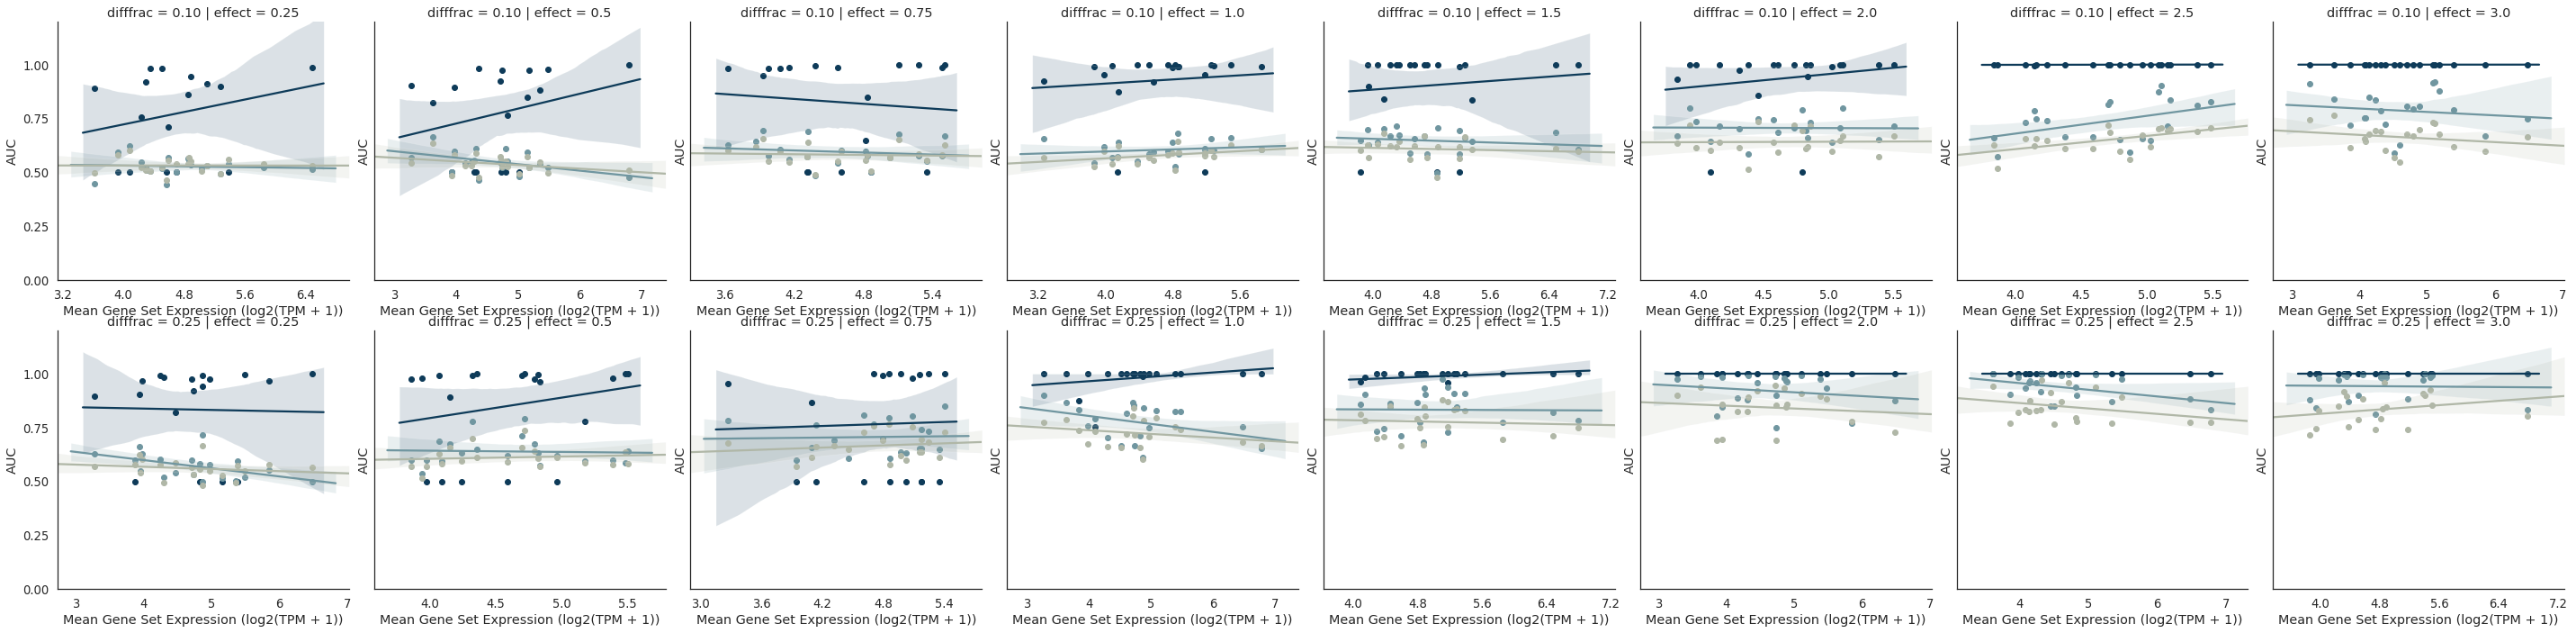

In [19]:
sns.set(style='white', font_scale=1.2)

g = sns.lmplot(x="gs_mean", 
               y='auc', 
               hue='method',
               row='difffrac',
               col='effect',
               data=plot_df,
               legend=False,
               palette=palette,
               scatter_kws={'alpha': 1.0},
               line_kws={'alpha': 1.0},
               sharex=False,
               sharey=True)

axes = g.axes

for row in axes:
    for ax in row:
        ax.set_ylim(0, 1.2)
        ax.set_xlabel('Mean Gene Set Expression (log2(TPM + 1))')
        ax.set_ylabel('AUC')

#g.ax.legend(title='Method', frameon=False, loc=(1.0, 0.4))

#pth = '/home/jpfeil/MEGAsync/Dropbox/hydra-paper/Figure2ROC/pan-hallmark-auc-vs-mean-plot-%s.svg' % date
#plt.savefig(pth, format='svg', bbox_inches='tight')

In [20]:
from scipy import stats

for i, rows in plot_df.groupby(['method', 'difffrac']):
    print(i)
    s, p = stats.pearsonr(rows['auc'], rows['gs_mean'])
    print(s, p)

('GSVA', '0.10')
(-0.01969305480149253, 0.8047762912908613)
('GSVA', '0.25')
(-0.0033693693086252166, 0.9662711235307762)
('Hydra', '0.10')
(nan, 1.0)
('Hydra', '0.25')
(nan, 1.0)
('ssGSEA', '0.10')
(-0.04609803634739752, 0.5627004541985392)
('ssGSEA', '0.25')
(-0.059906675076664584, 0.4517498823250957)


In [21]:
plot_df.head()

,method,gene-set,auc,gs_mean,effect,difffrac
0,Hydra,HALLMARK_ANGIOGENESIS,1.000000,5.177807,3.0,0.25
1,ssGSEA,HALLMARK_ANGIOGENESIS,0.884344,5.177807,3.0,0.25
2,GSVA,HALLMARK_ANGIOGENESIS,0.741779,5.177807,3.0,0.25
3,Hydra,HALLMARK_SPERMATOGENESIS,0.824908,3.624444,0.5,0.10
4,ssGSEA,HALLMARK_SPERMATOGENESIS,0.666003,3.624444,0.5,0.10


In [22]:
plot_df.loc[pd.isna(plot_df['auc']), ['gene-set', 'effect', 'difffrac']]

,gene-set,effect,difffrac
51,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.25,0.10
99,HALLMARK_HEDGEHOG_SIGNALING,0.25,0.10
195,HALLMARK_HEDGEHOG_SIGNALING,0.75,0.25
354,HALLMARK_NOTCH_SIGNALING,0.75,0.25
414,HALLMARK_INFLAMMATORY_RESPONSE,0.75,0.10
498,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.25,0.10
630,HALLMARK_APICAL_SURFACE,0.50,0.10
642,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.25,0.25
672,HALLMARK_IL2_STAT5_SIGNALING,0.50,0.10
822,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,0.25,0.10


In [23]:
lost_gs = plot_df.loc[pd.isna(plot_df['auc']), ['gene-set', 'effect', 'difffrac']]

for i, gs, eff, diff in lost_gs.itertuples():
    mask = (plot_df['gene-set'] == gs) & (plot_df['effect'] == eff) & (plot_df['difffrac'] == diff)
    plot_df = plot_df[~mask]

In [25]:
plot_df.loc[plot_df['difffrac'] == '0.10', '%DEG'] = '10%'
plot_df.loc[plot_df['difffrac'] == '0.25', '%DEG'] = '25%'

In [26]:
def mean_confidence_interval2(data, confidence=0.95):
    import scipy
    import numpy as np
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

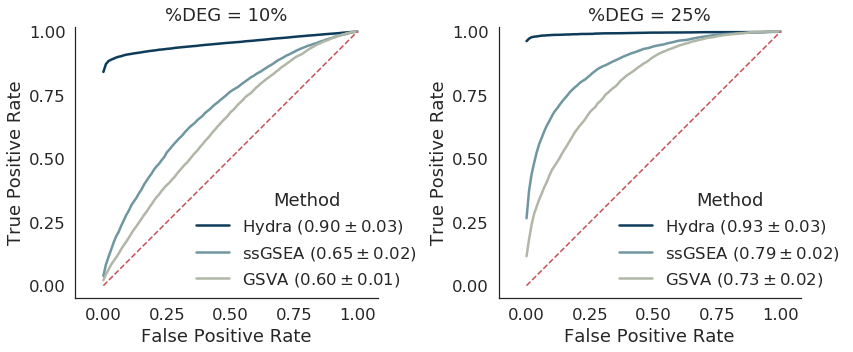

In [30]:
sns.set(style='white', font_scale=1.5)

# based on:
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

base_fpr = np.linspace(0, 1, 101)

diff_ind = {'0.10': 0, '0.25': 1}

for color, method, name in zip(palette,
                               ['hydra', 'ssgsea', 'gsva'],
                               ['Hydra', 'ssGSEA', 'GSVA']):

    for diff, l1 in datar[method].items():
        tprs = None
        for eff, l2 in l1.items():
            if float(eff) < 1.0:
                continue
            for gs, (fpr, tpr) in l2.items():
                mask = (plot_df['gene-set'] == gs) & (plot_df['effect'] == float(eff)) & (plot_df['difffrac'] == diff)
                if len(plot_df[mask]) == 0:
                    print('Skipping Lost Model', gs)
                    print(plot_df[mask])
                    continue
                
                #ax.plot(fpr, tpr, label=method)
                btpr = np.interp(base_fpr, fpr, tpr)
            
                if tprs is None:
                    tprs = btpr
            
                else:
                    tprs = np.vstack([btpr, tprs])
                    
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
    
        ax[diff_ind[diff]].plot([0.] + base_fpr, 
                                [0.] + mean_tprs, 
                                color, 
                                label=name,
                                linewidth=2.5)

for i in [0, 1]:
    ax[i].plot([0, 1], [0, 1],'r--')
    ax[i].set_xlim([-0.05, 1.02])
    ax[i].set_ylim([-0.05, 1.02])

    ax[i].set_ylabel("True Positive Rate")
    ax[i].set_xlabel("False Positive Rate")
    ax[i].set_aspect("equal", 'datalim')
    

ax[0].set_title("%DEG = 10%")
ax[1].set_title("%DEG = 25%")

#plt.title('Mean ROC Curve for HALLMARK Gene Sets')

hy1, hy2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'Hydra') & (plot_df['%DEG'] == '10%') , 'auc'])
ss1, ss2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'ssGSEA') & (plot_df['%DEG'] == '10%'), 'auc'])
gs1, gs2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'GSVA') & (plot_df['%DEG'] == '10%'), 'auc'])

L = ax[0].legend(title='Method', 
                 frameon=False,
                 bbox_to_anchor=(0.35, 0.45))

L.get_texts()[0].set_text("Hydra ($%.2f \pm %.2f$)" % (hy1, hy2))
L.get_texts()[1].set_text("ssGSEA ($%.2f \pm %.2f$)" % (ss1, ss2))
L.get_texts()[2].set_text("GSVA ($%.2f \pm %.2f$)" % (gs1, gs2))

hy1, hy2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'Hydra') & (plot_df['%DEG'] == '25%') , 'auc'])
ss1, ss2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'ssGSEA') & (plot_df['%DEG'] == '25%'), 'auc'])
gs1, gs2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'GSVA') & (plot_df['%DEG'] == '25%'), 'auc'])

L = ax[1].legend(title='Method', 
                 frameon=False,
                 bbox_to_anchor=(0.35, 0.45))

L.get_texts()[0].set_text("Hydra ($%.2f \pm %.2f$)" % (hy1, hy2))
L.get_texts()[1].set_text("ssGSEA ($%.2f \pm %.2f$)" % (ss1, ss2))
L.get_texts()[2].set_text("GSVA ($%.2f \pm %.2f$)" % (gs1, gs2))

sns.despine()


plt.subplots_adjust(wspace=0.4)

pth = 'img/ROC-plot-per-diff.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = 'img/ROC-plot-per-diff.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [31]:
plot_df

,method,gene-set,auc,gs_mean,effect,difffrac,%DEG
0,Hydra,HALLMARK_ANGIOGENESIS,1.000000,5.177807,3.00,0.25,25%
1,ssGSEA,HALLMARK_ANGIOGENESIS,0.884344,5.177807,3.00,0.25,25%
2,GSVA,HALLMARK_ANGIOGENESIS,0.741779,5.177807,3.00,0.25,25%
3,Hydra,HALLMARK_SPERMATOGENESIS,0.824908,3.624444,0.50,0.10,10%
4,ssGSEA,HALLMARK_SPERMATOGENESIS,0.666003,3.624444,0.50,0.10,10%
5,GSVA,HALLMARK_SPERMATOGENESIS,0.635672,3.624444,0.50,0.10,10%
6,Hydra,HALLMARK_SPERMATOGENESIS,1.000000,3.624444,2.00,0.25,25%
7,ssGSEA,HALLMARK_SPERMATOGENESIS,0.987654,3.624444,2.00,0.25,25%
8,GSVA,HALLMARK_SPERMATOGENESIS,0.939066,3.624444,2.00,0.25,25%
9,Hydra,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.989007,4.868248,1.00,0.25,25%


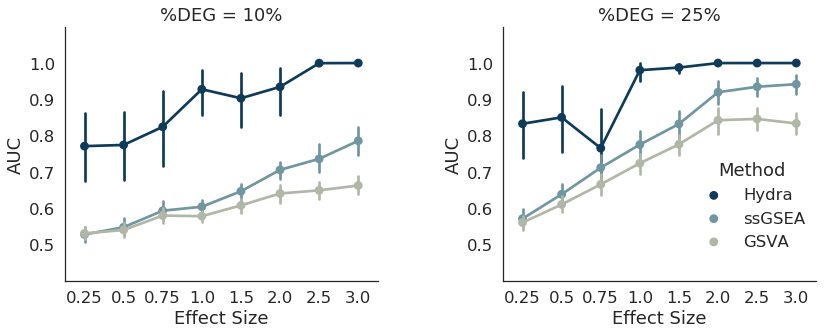

In [37]:
sns.set(style='white', font_scale=1.5)

g = sns.catplot(x='effect', 
                y='auc',
                hue='method',
                col='%DEG',
                col_order=['10%', '25%'],
                kind='point',
                data=plot_df,
                palette=palette,
                scatter_kws={'alpha': 1.0},
                line_kws={'alpha': 1.0},
                sharex=False,
                sharey=False,
                legend=False,
                aspect=1.2)

axes = g.axes

for row in axes:
    for ax in row:
        ax.set_ylim(0.4, 1.1)
        ax.set_xlabel('Effect Size')
        ax.set_ylabel('AUC')
        ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.subplots_adjust(wspace=0.4)

plt.legend(title='Method', frameon=False, loc=(0.6, 0.1))
        
pth = 'img/auc-vs-eff.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = 'img/auc-vs-eff.png'
plt.savefig(pth, format='png', bbox_inches='tight')